In [1]:
# importing  TicTacToe class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from collections import deque
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

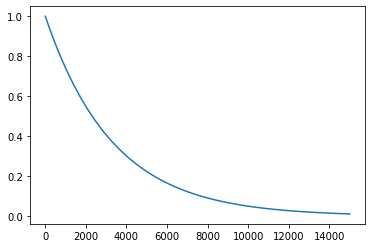

In [8]:
EPISODES = 15000
max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = -0.0003       # epsilon decay rate
epsilon = []
episd = np.arange(0,EPISODES)
for i in range(0,EPISODES):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(decay_rate*i))

plt.plot(episd, epsilon)
plt.show()

In [9]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.
def valid_actions(state):
    valid_Actions = []
    # calling action_space to get all possible actions
    valid_Actions = [i for i in env.action_space(state)[0]]
    return valid_Actions

In [10]:
'''
The environment class for the Tic-Tac-Toe problem. Provides methods for initialising a state,
checking whether the state is terminal or not,
computing new states and rewards given state and action etc.
'''

class TicTacToe():
    def __init__(self):
        """initialise the board"""
        # initialise state as an array
        # initialises the board position, can initialise to an array or matrix
        self.reset()
        # all possible numbers can initialise to an array or matrix
        self.all_possible_numbers = [1,2] 
    def is_winning(self, curr_state):
        """Takes state as an input and returns whether any row, column or diagonal has winning sum"""
        lines = [(0,1,2), (3,4,5), (6,7,8), (0,3,6), (1,4,7), (2,5,8), (0,4,8), (2,4,6)]
        for line in lines:
            if np.any(curr_state[line[0]]) and np.any(curr_state[line[0]]) and np.any(curr_state[line[0]]):
                if (curr_state[line[0]]==curr_state[line[1]]==curr_state[line[2]]==1):
                    return True
                elif (curr_state[line[0]]==curr_state[line[1]]==curr_state[line[2]]==2):
                    return True
        return False
    def is_terminal(self, curr_state):
        # Terminal state could be winning state or when the board is filled up
        if self.is_winning(curr_state) == True:
            return True, 'Win'
        elif len(self.allowed_positions(curr_state)) ==0:
            return True, 'Tie'
        else:
            return False, 'Resume'
    def allowed_positions(self,state):
        return np.where(state == 0)[0]
    def action_space(self, curr_state):
        """Takes the current state as input and returns all possible (unused) 
        values that can be placed on the board"""
        used_values = self.allowed_positions(curr_state)
        #used_values = [val for val in curr_state if not np.isnan(val)]
        agent_values = [(val,1) for val in used_values]
        env_values = [(val,2) for val in used_values]
        return [agent_values, env_values]
    def state_transition(self, curr_state, curr_action):
        """Takes current state and action and returns the board position just after agent's move."""
        position = curr_action[0]
        value = curr_action[1]
        curr_state[position] = value 
        return curr_state
    def step(self, curr_state, curr_action):
        """Takes current state and action and returns the next state and reward. 
        First, check the board position after agent's move, whether the game is won/loss/tied. 
        Then incorporate environment's move and again check the board status."""
        terminal_state = False
        used_values = np.where(curr_state!=0)[0]
        temp_state = self.state_transition(curr_state, curr_action)
        if [val for val in used_values if val == curr_action[0]]:
            # illegal move 
            reward = -40
            terminal_state = True
            game_status = 'Illegal'
        else:
            terminal_state, game_status = self.is_terminal(temp_state)
            if terminal_state == True:
                if game_status == 'Win':
                    reward=10
                else:
                    reward=0
            else:
                position,value = random.choice(self.action_space(temp_state)[1])
                temp_state[position]= value
                terminal_state, game_status = self.is_terminal(temp_state)
                if terminal_state == True:
                    if game_status == 'Win':
                        reward=-10
                        game_status = 'Loose'
                    else:
                        reward=0
                else:
                    reward=-1
        return temp_state, reward, terminal_state,game_status
    def reset(self):
        self.state = np.zeros(9,dtype=int)
        return self.state

In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01 
        self.epsilon_max = 1
        self.epsilon_min = 0.001
        self.epsilon_decay = -0.0003
        self.epsilon = 1
        
        self.batch_size = 256
        # create replay memory using deque
        self.memory = deque(maxlen=512)
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        #model.summary()
        return model
    
    def encode(self,state):
        en = en = np.zeros([9,3],dtype=int)
        for i,l in enumerate(state):
            en[i][l] = 1
        return en.reshape(1,27)
    
    def update_epsilon(self,episode):
        self.epsilon = (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * episode)

    def get_action(self, state):
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        possible_actions = valid_actions(state)
        if np.random.rand() <= self.epsilon:
            return random.choice(possible_actions)
        else :
            q_value = self.model.predict(self.encode(state))
            # truncate the array to only those actions that are part of the ride  requests.
            return (np.argmax(q_value),1)
        #self.epsilon = (self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*i))

    def append_sample(self, curr_state, action, reward, next_state,done):
        # save sample <s,a,r,s'> to the replay memory
        #print(curr_state, action, reward, next_state,done)
        self.memory.append((curr_state, action, reward, next_state, done))
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_bool = mini_batch[i]
                update_input[i] = self.encode(state)
                actions.append(action)
                rewards.append(reward)
                done.append(done_bool)
                update_output[i] = self.encode(next_state)
                
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)    
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)    
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i][0]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                else:
                    target[i][actions[i][0]] = rewards[i]
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

In [13]:
Episodes = 15000
start_time = time.time()
episode_time= time.time()
agent_won = 0
envn_won = 0
tie_cnt = 0
chk_prt_epsd = 500
env = TicTacToe()
agent = DQNAgent(3*3*3,3*3)
#agent.model.load_weights('model12')
score = 0
status = 'Tie'
ilcnt = 0
wincnt = 0 
locnt = 0
ticnt = 0
dfcnt = 0

for episode in range(Episodes):
    curr_state = []
    curr_state = env.reset()
    terminal_state = False
    while not terminal_state:
        state = curr_state.copy()
        action = agent.get_action(state)
        next_state, reward,terminal_state,status = env.step(state, action)
        agent.append_sample(curr_state,action,reward,next_state,terminal_state)
        curr_state = next_state
        score += reward
        agent.train_model()
        
    if status == 'Illegal':
        ilcnt += 1;
    elif status == 'Win':
        wincnt += 1
    elif status == 'Loose':
        locnt += 1
    elif status == 'Tie':
        ticnt += 1
    else:
        dfcnt += 1
    agent.update_epsilon(episode)
    if (episode % chk_prt_epsd) == 0:
        print(f'Episode: {episode} Epsilon: {agent.epsilon:.2f} Reward: {score} ElTime:{time.time() - episode_time:.2f}')
        print(f'win:{wincnt} Lost:{locnt} Tie:{ticnt} Illegal:{ilcnt} Dlf:{dfcnt}')
        score = 0
        status = 'Tie'
        ilcnt = 0
        wincnt = 0 
        locnt = 0
        ticnt = 0
        dfcnt = 0
        episode_time = time.time()
        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Episode: 0 Epsilon: 1.00 Reward: -4 ElTime:0.03
win:0 Lost:0 Tie:1 Illegal:0 Dlf:0
Episode: 500 Epsilon: 0.86 Reward: -2409 ElTime:214.63
win:263 Lost:118 Tie:62 Illegal:57 Dlf:0
Episode: 1000 Epsilon: 0.74 Reward: -6631 ElTime:221.99
win:205 Lost:111 Tie:31 Illegal:153 Dlf:0
Episode: 1500 Epsilon: 0.64 Reward: -10773 ElTime:215.02
win:155 Lost:64 Tie:22 Illegal:259 Dlf:0
Episode: 2000 Epsilon: 0.55 Reward: -10243 ElTime:214.68
win:166 Lost:72 Tie:15 Illegal:247 Dlf:0
Episode: 2500 Epsilon: 0.47 Reward: -7714 ElTime:237.04
win:210 Lost:78 Tie:22 Illegal:190 Dlf:0
Episode: 3000 Epsilon: 0.41 Reward: -7787 ElTime:229.69
win:201 Lost:83 Tie:26 Illegal:190 Dlf:0
Episode: 3500 Epsilon: 0.35 Reward: -9514 ElTime:233.58
win:184 Lost:76 Tie:9 Illegal:231 Dlf:0
Episode: 4000 Epsilon: 0.30 Reward: -16464 ElTime:187.84
win:65 Lost:37 Tie:4 Illegal:394 Dlf:0
Episode: 4500 Epsilon: 0.26 Reward: -13635 ElTime:210.73
win:128 Lost:35 Tie:1 Illegal:336 Dlf:0
Episode: 5000 Epsilon: 0.22 Reward: -9124 El

In [14]:
agent.model.save_weights('model12')

In [ ]:
agent.model.load_weights('model12')